In [ ]:
from astropy import units as u, constants as const
from astropy.table import Table
from astropy.io import fits
import numpy as np
from scipy import interpolate
import pandas as pd

In [22]:
G_filter = Table.read('data/GAIA.GAIA0.G.votable')
Bp_filter = Table.read('data/GAIA.GAIA0.Gbp.votable.xml', format='votable')
Rp_filter = Table.read('data/GAIA.GAIA0.Grp.votable.xml', format='votable')

VEGA_RADIUS = 2.5 * u.R_sun
VEGA_TEMPERATURE = 9607 * u.K
VEGA_DISTANCE = 25.05 * u.lightyear
VEGA_FILTER = Table.read('data/alpha_lyr_mod_004.fits', format='fits')
VEGA_WAVE = VEGA_FILTER['WAVELENGTH'].value * u.Angstrom
VEGA_FLUX = VEGA_FILTER['FLUX'].value * u.erg/u.s/u.cm**2/u.angstrom
PLEIADES_DISTANCE = 444 * u.lyr


In [23]:
def blackbody_intensity(temperature, wavelength):
    
    prefactor = 2 * ((const.h * const.c**2) / wavelength**5)
    return (
        prefactor
        / (np.exp((const.h * const.c) / (np.outer(temperature, wavelength) * const.k_B)) - 1)
    ).to(u.erg / u.s / u.cm**2 / u.angstrom)


def blackbody_flux(temperature, wavelength):
    return np.pi * blackbody_intensity(temperature, wavelength).to(
        u.erg / u.s / u.cm**2 / u.angstrom
    )


def model_star(temperature, star_radius, distance, wavelength):
    return (
        (blackbody_flux(temperature, wavelength) * star_radius**2 / distance**2)
    ).to(u.erg / u.s / u.cm**2 / u.angstrom)


In [ ]:
model_star(np.arange(3000, 6000)* u.K, 1 * u.R_sun, 10 * u.pc, np.arange(2000, 9000) * u.Angstrom)

181 ms ± 6.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
def mean_flux_bb_filter(temperature, star_radius, distance, filter):
    flux_model = model_star(
        temperature, star_radius, distance, filter["Wavelength"].quantity
    )
    flux_int = np.trapz(
        flux_model * filter["Transmission"].quantity * filter["Wavelength"].quantity, filter["Wavelength"].quantity
    )
    filter_int = np.trapz(
        filter["Transmission"].quantity * filter["Wavelength"].quantity, filter["Wavelength"].quantity
    )
    return (flux_int / filter_int).to(u.erg / u.s / u.angstrom / u.cm**2)

def mean_flux_spectrum_filter(star_wave, star_flux, filter):
    interp_filter_transmission = np.interp(
        star_wave, filter["Wavelength"].quantity, filter["Transmission"].quantity
    )
    flux_int = np.trapz(
        star_flux * interp_filter_transmission * star_wave, star_wave
    )
    filter_int = np.trapz(
        filter["Transmission"].quantity *  filter["Wavelength"].quantity, filter["Wavelength"].quantity
    )
    return (flux_int / filter_int).to(u.erg / u.s / u.angstrom / u.cm**2)

def mean_flux_G(temperature, star_radius, distance):
    return mean_flux_bb_filter(temperature, star_radius, distance, G_filter)


def mean_flux_Bp(temperature, star_radius, distance):
    return mean_flux_bb_filter(temperature, star_radius, distance, Bp_filter)


def mean_flux_Rp(temperature, star_radius, distance):
    return mean_flux_bb_filter(temperature, star_radius, distance, Rp_filter)

In [6]:
def model_star_vega_mag(temperature, star_radius, distance, filter):
    mean_flux_bb = mean_flux_bb_filter(temperature, star_radius, distance, filter)
    mean_flux_vega = mean_flux_spectrum_filter(VEGA_WAVE, VEGA_FLUX, filter)
    return -2.5 * np.log10(mean_flux_bb / mean_flux_vega)

def model_star_cmd(temperature, star_radius, distance):
    G_mag = model_star_vega_mag(temperature, star_radius, distance, G_filter)
    Bp_mag = model_star_vega_mag(temperature, star_radius, distance, Bp_filter)
    Rp_mag = model_star_vega_mag(temperature, star_radius, distance, Rp_filter)
    return (Bp_mag - Rp_mag).value, G_mag.value

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


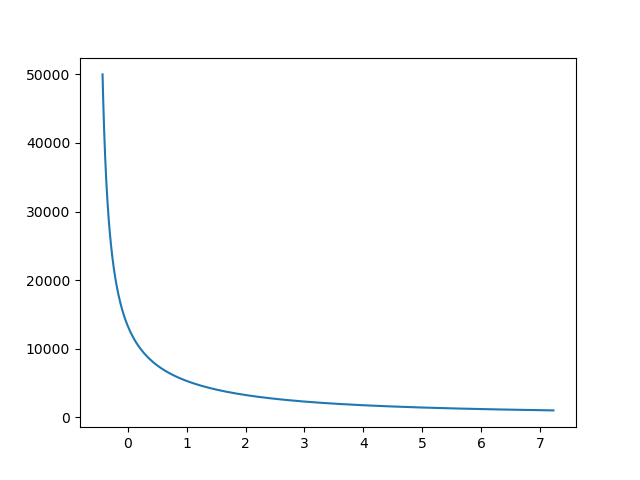

In [59]:
%pylab widget
## converting between colors to temperatures

temps = np.arange(1000, 50000) * u.K
colors, mags = model_star_cmd(temps, VEGA_RADIUS, VEGA_DISTANCE)
plot(colors, temps)

color_temp_interp = interpolate.interp1d(colors, temps)

In [ ]:
pleiades = Table.read('data/pleiades_prop_mot_sel.votable', format='votable')
#westerlund1 = Table.read('data/westerlund1_gaiadr2_2m.votable', format='votable')
#westerlund1_oc = oc_df[oc_df['Cluster'] == 'Westerlaund_1']

3.956293

In [65]:
pleiades_color, pleiades_mag = pleiades['bp_rp'], pleiades['phot_g_mean_mag']
pleiades_mask = pleiades_color.mask | pleiades_mag.mask
pleiades_color = pleiades_color[~pleiades_mask].data.data
pleiades_mag = pleiades_mag[~pleiades_mask].data.data
pleiades_temperatures = color_temp_interp(pleiades_color) * u.K

In [68]:
%%timeit
model_pleiades_color, model_pleiades_mag = model_star_cmd(pleiades_temperatures, VEGA_RADIUS, PLEIADES_DISTANCE)

13.5 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


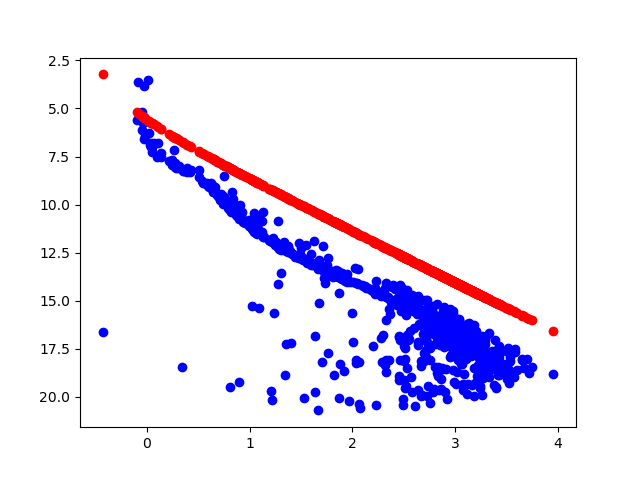

In [69]:
%pylab widget

ax = gca()
plot(pleiades_color, pleiades_mag, 'bo')
plot(model_pleiades_color, model_pleiades_mag, 'ro')
ax.invert_yaxis()

In [70]:
def neg_log_likelihood(distance):
    model_pleiades_color, model_pleiades_mag = model_star_cmd(pleiades_temperatures, 1 * u.R_sun, distance)
    return np.sum((model_pleiades_color - pleiades_color)**2)
    


In [72]:
%%timeit
neg_log_likelihood(444 * u.lyr)

13.5 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
